# Лабораторная работа 1. Визуализация и предварительная обработка данных

### Жунёв Андрей Александрович РИМ-150950

# I. ВВЕДЕНИЕ

## 1.1 Описание задачи

**Тип задачи:** Регрессия  
**Целевая переменная:** Financial Loss (in Million $) - финансовый ущерб от кибератаки  
**Бизнес-контекст:** Оценка ущерба позволяет бизнесу лучше спланировать защитные меры, определить бюджеты безопасности.

## 1.2 Описание датасета

**Источник данных:** Kaggle  
**Датасет:** Global Cybersecurity Threats (2015-2024)  
**Размерность:** ~3000 записей, 10 признаков  
**Ссылка:** https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024

# II. ПОДГОТОВКА РАБОЧЕЙ СРЕДЫ

## 2.1 Импорт библиотек

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

## 2.2 Загрузка данных

In [2]:
path = 'data/global-cybersecurity-threats/GCT_20152024.csv'
df = pd.read_csv(path, delimiter=',')

print(f"Размерность: {df.shape}")
df.head()

Размерность: (3000, 10)


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


# III. РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

## 3.1 Первичный осмотр данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.5+ KB


In [4]:
print("Пропуски:", df.isnull().sum().sum())
print("Дубликаты:", df.duplicated().sum())

Пропуски: 0
Дубликаты: 0


In [5]:
cat_columns = [col for col in df.columns if df[col].dtype == 'object']
num_columns = [col for col in df.columns if df[col].dtype != 'object']

print(f"Категориальные ({len(cat_columns)}): {cat_columns}")
print(f"Числовые ({len(num_columns)}): {num_columns}")

Категориальные (6): ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']
Числовые (4): ['Year', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']


## 3.2 Анализ дубликатов

In [6]:
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Удалено {duplicates} дубликатов")
else:
    print("Дубликаты не обнаружены")

Дубликаты не обнаружены


## 3.3 Анализ числовых признаков

### 3.3.1 Описательная статистика

In [37]:
df.describe()


,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours)
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2019.570333,50.492970,504684.136333,36.476000
std,2.857932,28.791415,289944.084972,20.570768
min,2015.000000,0.500000,424.000000,1.000000
25%,2017.000000,25.757500,255805.250000,19.000000
50%,2020.000000,50.795000,504513.000000,37.000000
75%,2022.000000,75.630000,758088.500000,55.000000
max,2024.000000,99.990000,999635.000000,72.000000


### 3.3.2 Распределение числовых признаков в обычной шкале

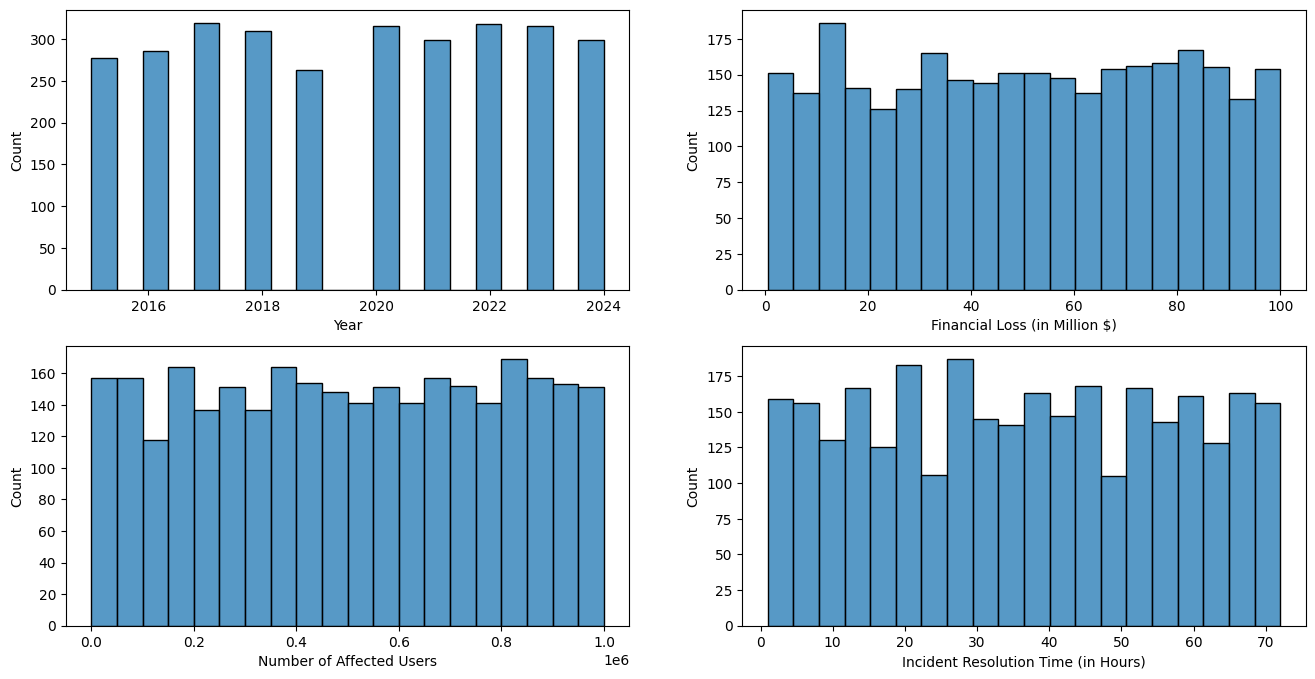

In [69]:
width = 2
height = int(np.ceil(len(num_columns)/width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(16,8)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет height строк и width столбцов

for idx, column_name in enumerate(num_columns): # перебираем все числовые данные
    plt.subplot(height,width, idx+1) #берем конкретную ячейку из заранее подготовленную заготовку
    # рисуем с помощью библиотеки seaborn
    sns.histplot(data=df, # какой датафрейм используем
            x=column_name, # какую переменную отрисовываем
            bins = 20);  # на сколько ячеек разбиваем


Нет смысла переводить в логарифмическую шкалу. Наблюдается достаточно равномерное распределение для всех признаков (year пока не учитываем, о нем ниже). Есть провалы в частоте в признаке описывающим время для ликвидации последствий атаки, но незначаительные. Требуется масштабирование признаков (MinMaxScaler либо StandartScaler) для решения проблемы разных масштабов, чтобы отдельные признаки не перетягивали одеяло на себя.

### 3.3.3 Общий анализ: ящики с усами для всех числовых признаков


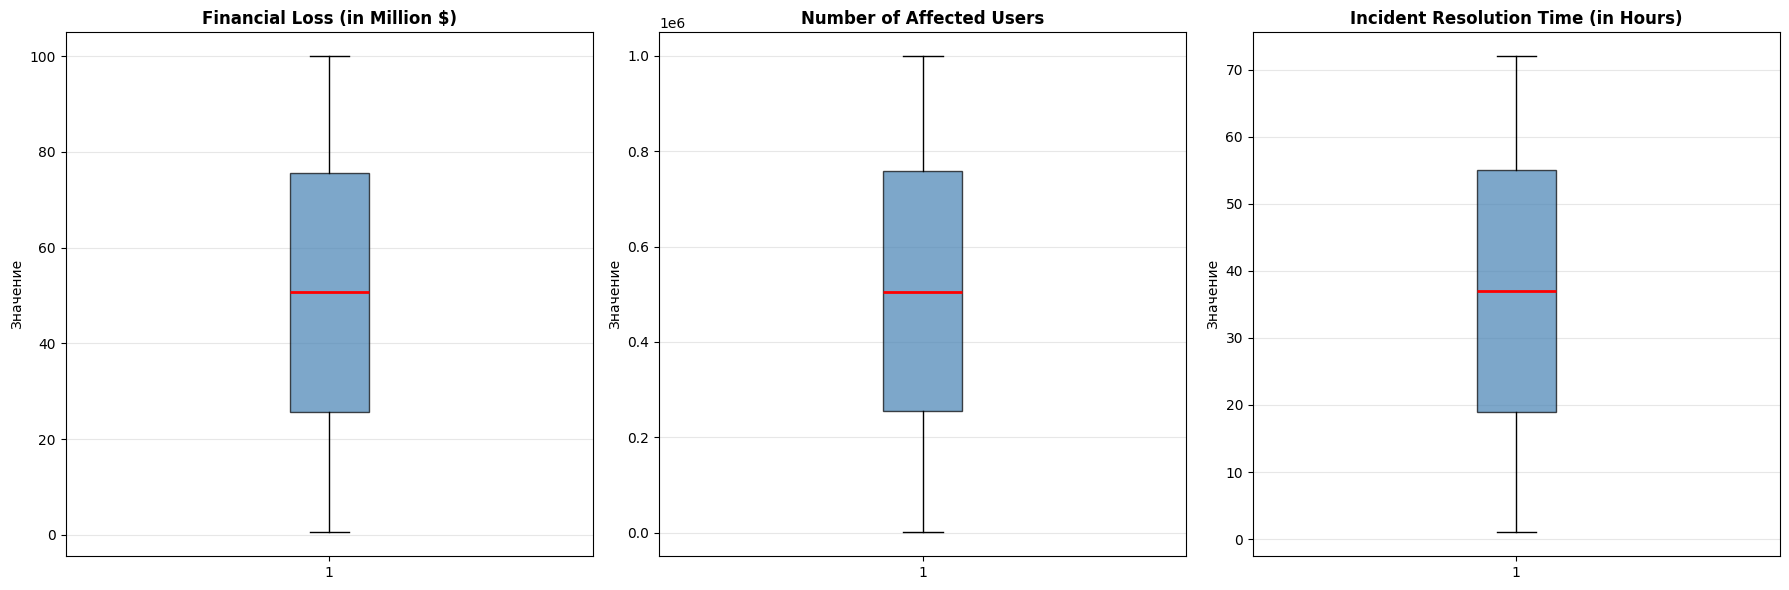

In [51]:
# Box plot для всех числовых признаков (кроме Year)
cols_to_visualize = [col for col in num_columns if col != 'Year']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, col in enumerate(cols_to_visualize):
    axes[idx].boxplot(df[col], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='steelblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    axes[idx].set_ylabel('Значение')
    axes[idx].set_title(col, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Видно, что выбросы отсутствуют, подтверждаются выводы, сделанные ранее

### 3.3.4 Анализ Year - распределение по годам


/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/3552738489.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(year_country_data, labels=sorted(df['Year'].unique()))


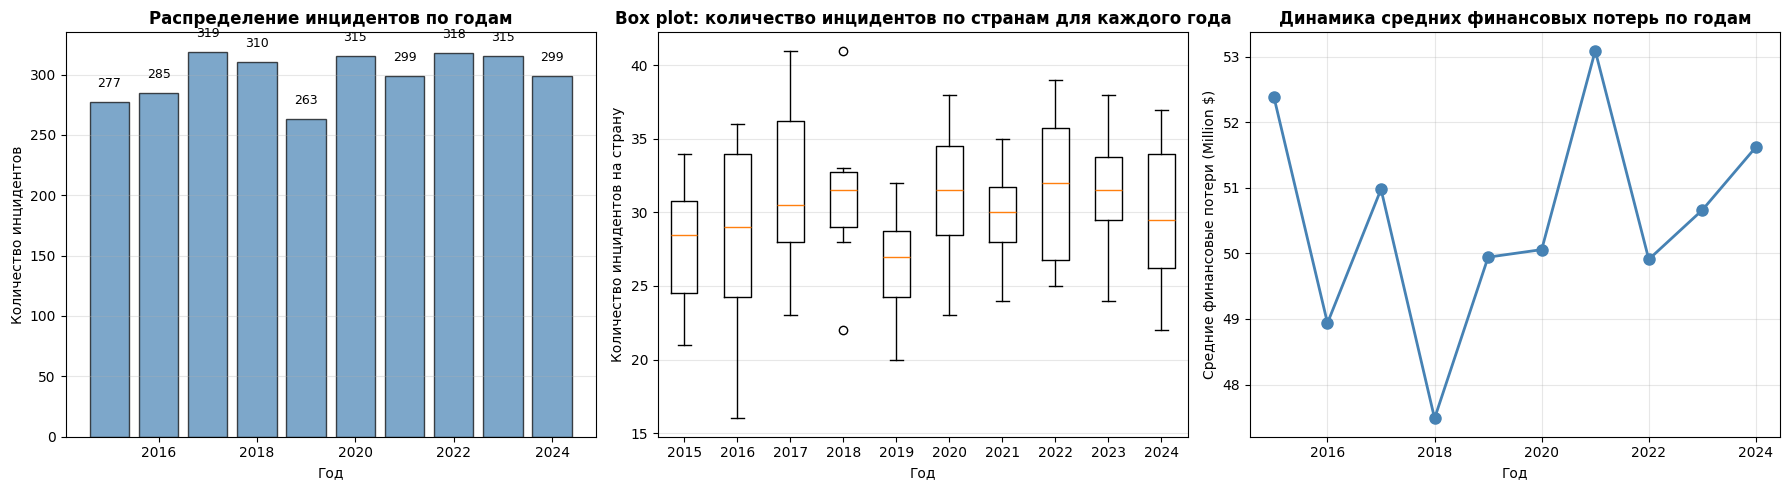

In [55]:
# Анализ распределения по годам
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Левая: столбчатая диаграмма по годам
year_counts = df['Year'].value_counts().sort_index()
axes[0].bar(year_counts.index, year_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Количество инцидентов')
axes[0].set_title('Распределение инцидентов по годам', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Добавление подписей
for year, count in year_counts.items():
    axes[0].text(year, count + 10, str(count), ha='center', va='bottom', fontsize=9)

# Средняя: boxplot по странам и годам
year_country_data = []
for year in sorted(df['Year'].unique()):
    year_data = df[df['Year'] == year].groupby('Country').size()
    year_country_data.append(year_data.values)

axes[1].boxplot(year_country_data, labels=sorted(df['Year'].unique()))
axes[1].set_xlabel('Год')
axes[1].set_ylabel('Количество инцидентов на страну')
axes[1].set_title('Box plot: количество инцидентов по странам для каждого года', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Правая: средние финансовые потери по годам
year_loss = df.groupby('Year')['Financial Loss (in Million $)'].mean()
axes[2].plot(year_loss.index, year_loss.values, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[2].set_xlabel('Год')
axes[2].set_ylabel('Средние финансовые потери (Million $)')
axes[2].set_title('Динамика средних финансовых потерь по годам', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Изначальная мысль использовать года как числовой признак требует пересмотра. По динамике средних финансовых потерь видно, что отсутствует четкий тренд на рост или спад, лучше в данном случае воспринимать признак как просто определенный паттерн.
Отнесем признак к категориальному

### 3.3.5 Корреляционный анализ числовых признаков


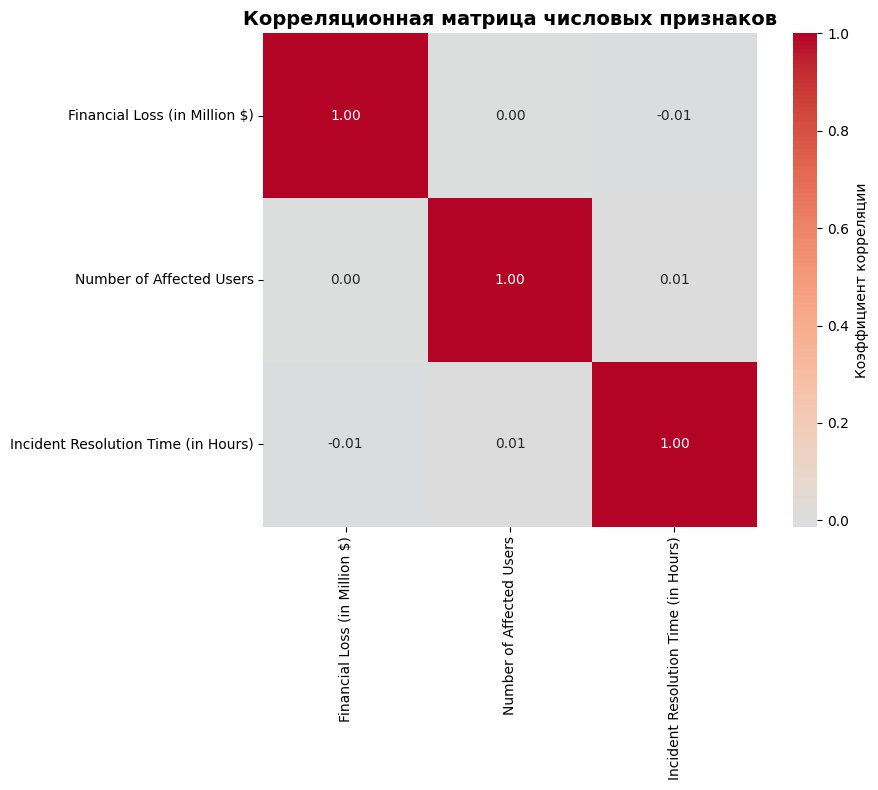

In [73]:
# Корреляционная матрица для числовых признаков
corr_matrix = df[cols_to_visualize].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, cbar_kws={'label': 'Коэффициент корреляции'})
plt.title('Корреляционная матрица числовых признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Вывод значимых корреляций
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.3:
            print(f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_value:.3f}")


Видим, что взаимосвязь между признаками отсутствует - возможно, это связано с тем, как изначально был собран датасет. Признаки несут уникальную информацию, что даст модели получить доп информацию из каждого изи признаков. следует проверить категориальные признаки для нахождения зависимостей

<Figure size 1500x1500 with 0 Axes>

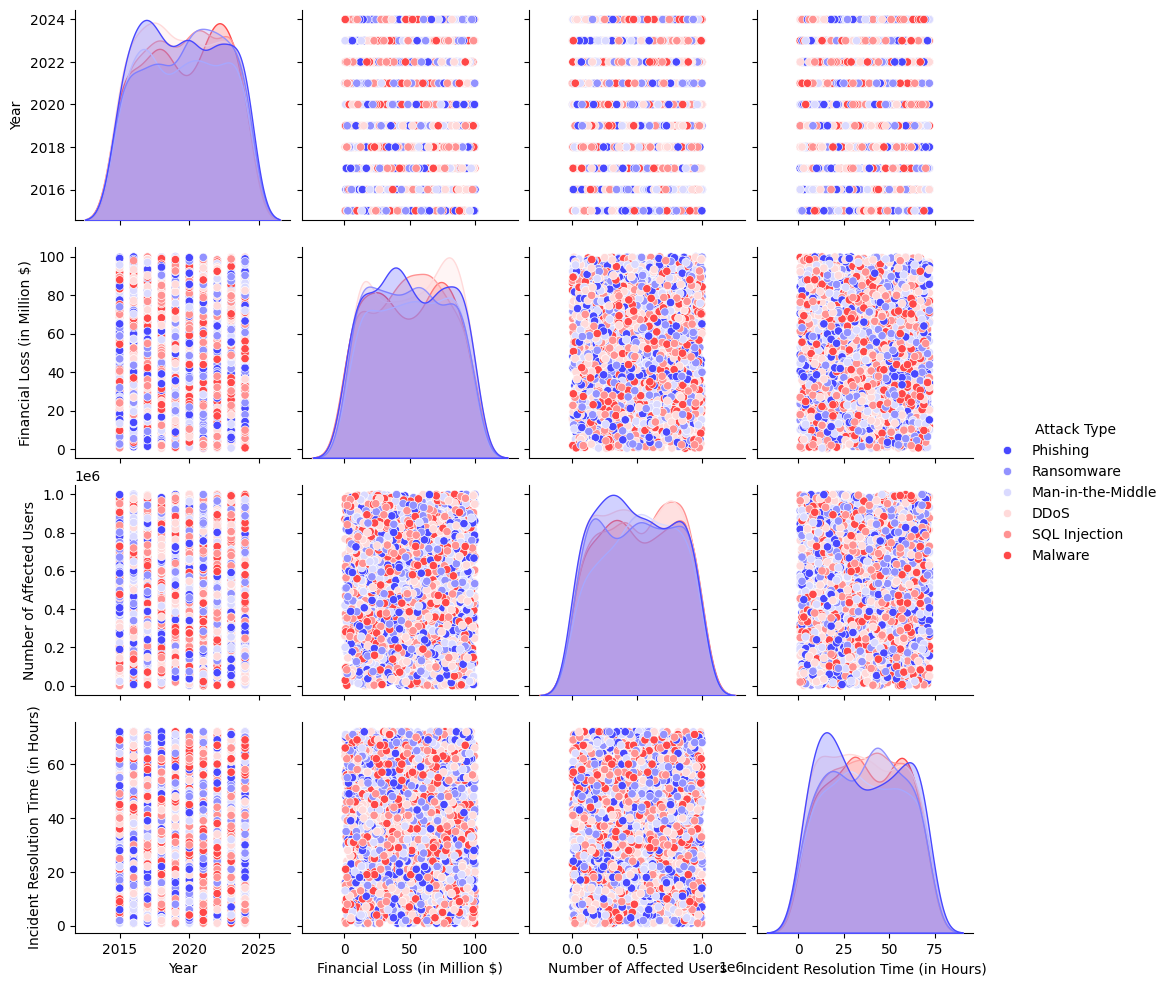

In [80]:
fig = plt.figure(figsize=(15,15))
sns.pairplot(data = df,  # какой датафрей используем
             hue ='Attack Type', # какую переменную используем для подкрашиваиния данных.
                                # Рекомендуется использовать Категориальные данные (не очень много уникальных значений)
             palette = 'bwr',); # какую цветовую карту используем. Здесь у нас всего 2 варианта, то мы используем bwr - один из Diverging
                                # если категорий больше, то лучше использовать что-то из Qualitative


По итогам анализа pairplot чувствуется, что природа финансовых потерь в кибератаках не зависит от типа атаки или масштабов инцидента — всё перемешано настолько, что ни один тип не выделяется ни по ущербу, ни по времени решения. Проще говоря, нет явных "дорогих" или "массовых" паттернов: Phishing, DDoS или Ransomware могут нанести ущерб любого размера и затронуть сколь угодно пользователей. Это значит, что настоящую информацию о риске для прогноза надо искать не в числовых признаках и не по виду атаки, а в категориях вроде отрасли, страны или их пересечениях.

## 3.4 Анализ категориальных признаков

In [9]:
for col in cat_columns:
    print(f"\n{col}: {df[col].nunique()} уникальных значений")
    print(df[col].value_counts()[:5])


Country: 10 уникальных значений
Country
UK        321
Brazil    310
India     308
France    305
Japan     305
Name: count, dtype: int64

Attack Type: 6 уникальных значений
Attack Type
DDoS             531
Phishing         529
SQL Injection    503
Ransomware       493
Malware          485
Name: count, dtype: int64

Target Industry: 7 уникальных значений
Target Industry
IT            478
Banking       445
Healthcare    429
Retail        423
Education     419
Name: count, dtype: int64

Attack Source: 4 уникальных значений
Attack Source
Nation-state    794
Unknown         768
Insider         752
Hacker Group    686
Name: count, dtype: int64

Security Vulnerability Type: 4 уникальных значений
Security Vulnerability Type
Zero-day              785
Social Engineering    747
Unpatched Software    738
Weak Passwords        730
Name: count, dtype: int64

Defense Mechanism Used: 5 уникальных значений
Defense Mechanism Used
Antivirus             628
VPN                   612
Encryption            

### 3.4.1 Распределение категориальных признаков


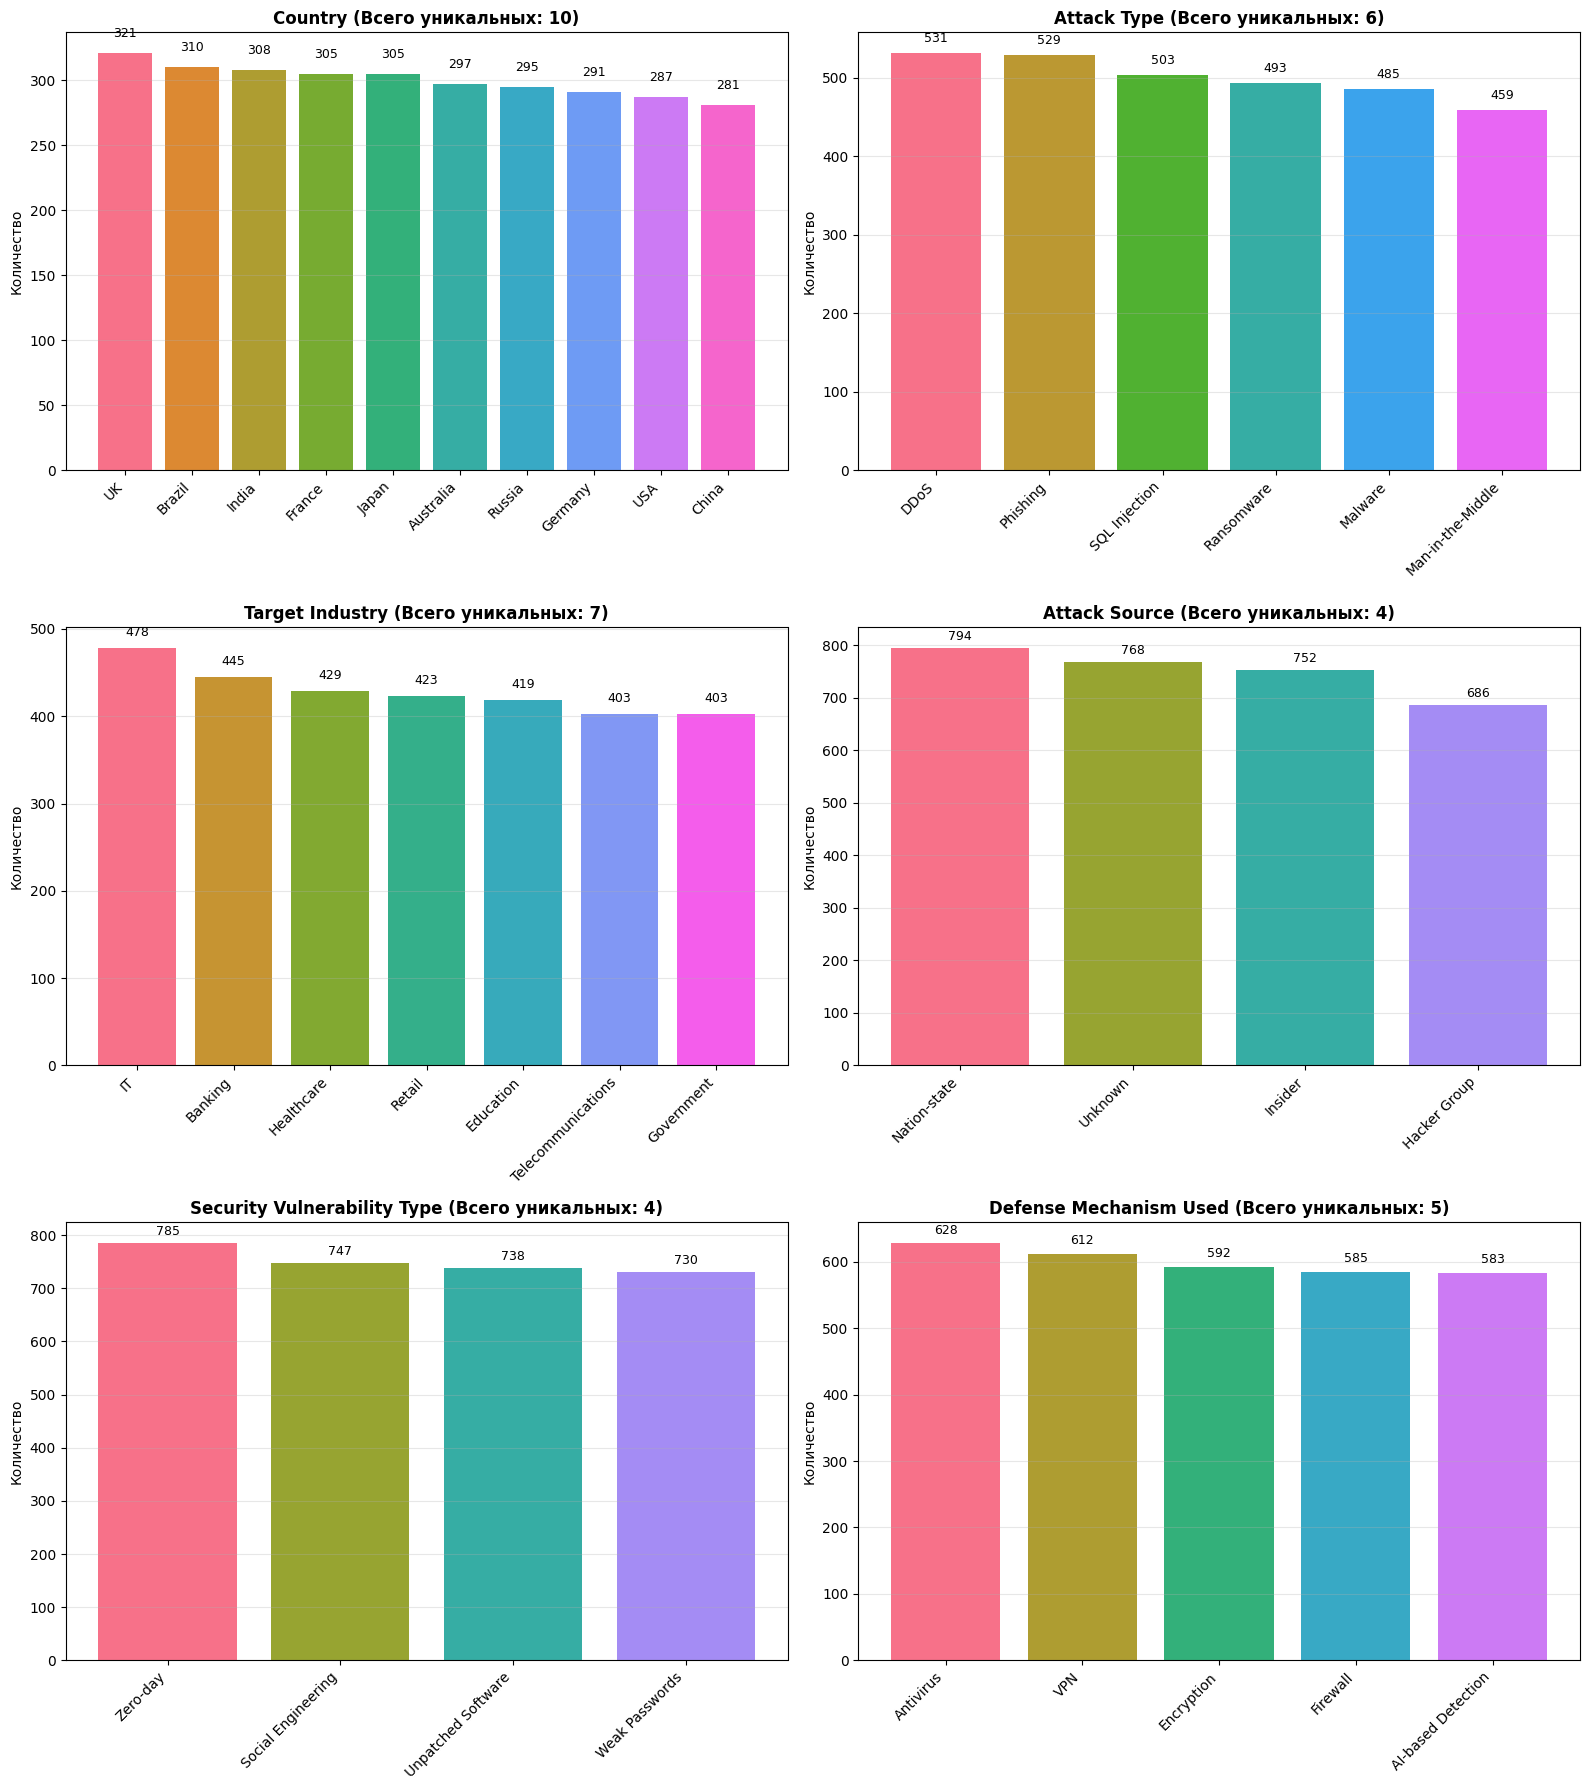

In [24]:
# Создание фигуры для всех категориальных признаков
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(cat_columns):
    # Подсчет значений
    value_counts = df[col].value_counts()
    
    # Построение барного графика
    bars = axes[idx].bar(range(len(value_counts)), value_counts.values, 
                        color=sns.color_palette("husl", len(value_counts)))
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].set_title(f'{col} (Всего уникальных: {df[col].nunique()})', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Количество')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Добавление подписей на столбцы
    for i, v in enumerate(value_counts.values):
        axes[idx].text(i, v + 10, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Количество вхождений в каждый класс примерно равное, следовательно, можно использовать one-hot encoding без боязни переобучения.

### 3.4.2 Анализ взаимосвязи атакованной страны и вызыванных финансовых потерь


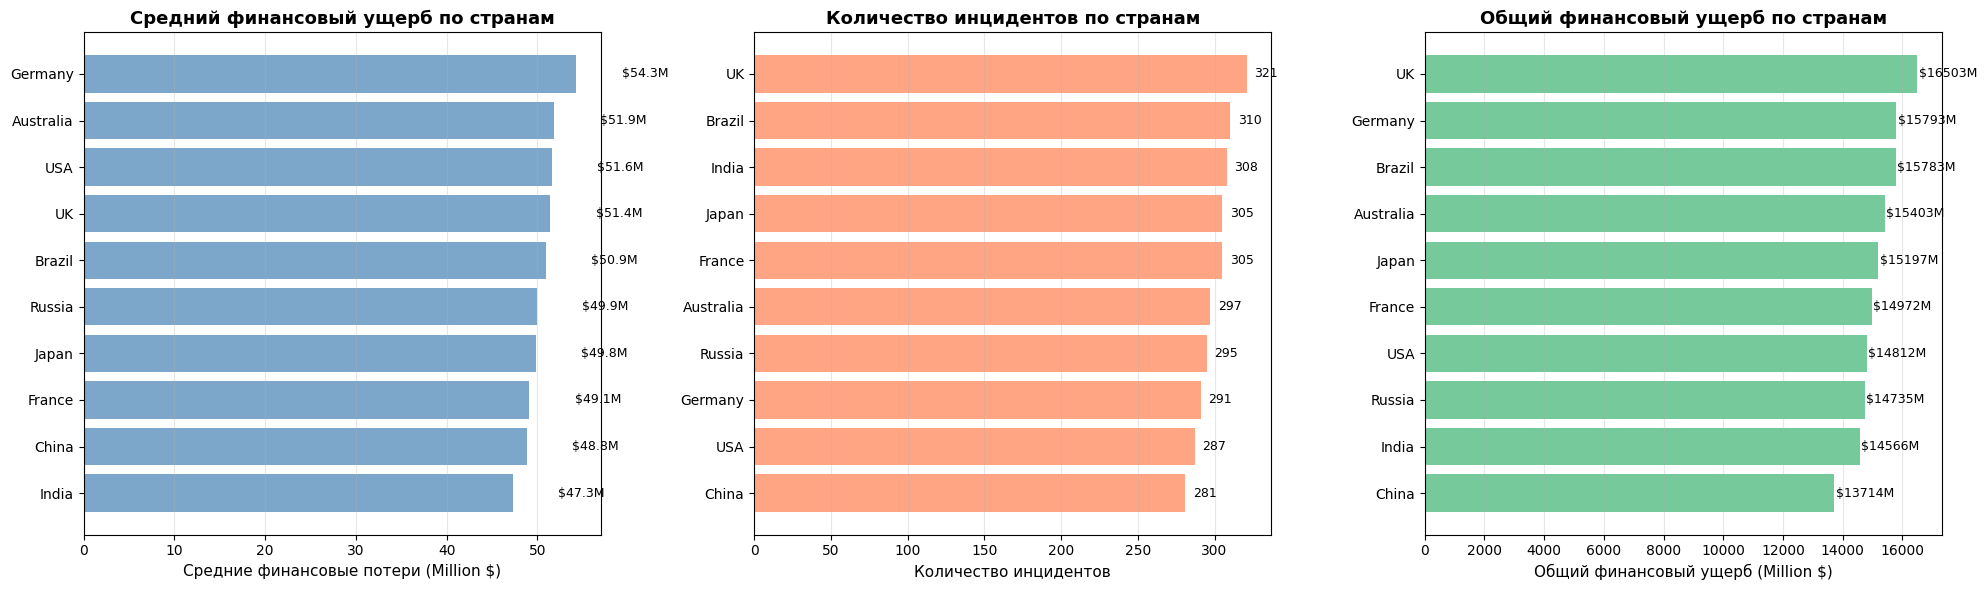

In [77]:
# Анализ финансовых потерь по странам
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. График средних финансовых потерь по странам
country_loss_mean = df.groupby('Country')['Financial Loss (in Million $)'].mean().sort_values(ascending=True)

axes[0].barh(range(len(country_loss_mean)), country_loss_mean.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(country_loss_mean)))
axes[0].set_yticklabels(country_loss_mean.index)
axes[0].set_xlabel('Средние финансовые потери (Million $)', fontsize=11)
axes[0].set_title('Средний финансовый ущерб по странам', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Добавление подписей
for i, v in enumerate(country_loss_mean.values):
    axes[0].text(v + 5, i, f'${v:.1f}M', va='center', fontsize=9)

# 2. График количества инцидентов по странам
country_counts = df['Country'].value_counts().sort_values(ascending=True)

axes[1].barh(range(len(country_counts)), country_counts.values, color='coral', alpha=0.7)
axes[1].set_yticks(range(len(country_counts)))
axes[1].set_yticklabels(country_counts.index)
axes[1].set_xlabel('Количество инцидентов', fontsize=11)
axes[1].set_title('Количество инцидентов по странам', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Добавление подписей
for i, v in enumerate(country_counts.values):
    axes[1].text(v + 5, i, f'{v}', va='center', fontsize=9)

# 3. График общего финансового ущерба по странам
country_loss_total = df.groupby('Country')['Financial Loss (in Million $)'].sum().sort_values(ascending=True)

axes[2].barh(range(len(country_loss_total)), country_loss_total.values, color='mediumseagreen', alpha=0.7)
axes[2].set_yticks(range(len(country_loss_total)))
axes[2].set_yticklabels(country_loss_total.index)
axes[2].set_xlabel('Общий финансовый ущерб (Million $)', fontsize=11)
axes[2].set_title('Общий финансовый ущерб по странам', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

# Добавление подписей
for i, v in enumerate(country_loss_total.values):
    axes[2].text(v + 50, i, f'${v:.0f}M', va='center', fontsize=9)

plt.tight_layout()
plt.show()


Распределение также плюс минус равномерное. Среди стран выделяется германия - на нее совершено меньше атак, но она лидирует по среднему финансовому ущербу и на втором месте по совокупному ущербу. Стоит посмотреть на пересечения между странами и индустриями или странами и типам атак, которым они подвергались

### 3.4.3 Тепловая карта распределения атак по странам и отраслям


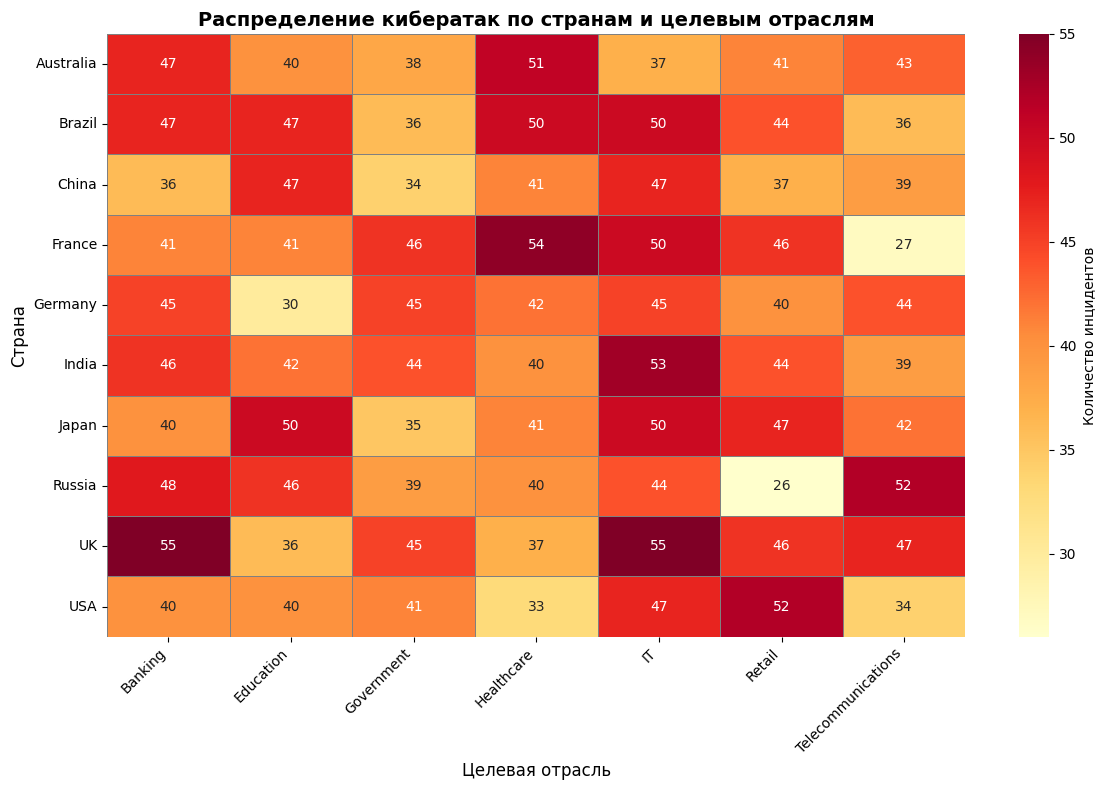

In [82]:
# Тепловая карта распределения атак по странам и отраслям
crosstab_country_industry = pd.crosstab(df['Country'], df['Target Industry'])
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_country_industry, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Количество инцидентов'}, linewidths=0.5, linecolor='gray')
plt.title('Распределение кибератак по странам и целевым отраслям', fontsize=14, fontweight='bold')
plt.xlabel('Целевая отрасль', fontsize=12)
plt.ylabel('Страна', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


IT и банковая система чаще всего подвергаются атакам в определенных странах особенн (Великобритания). В свою очередь, во Франции страдает здравоохранение, а в России телеком. Из этого можно сделать вывод, что можно воспринимать страну\отрасль как перекрестный признак важный для модели

### 3.4.4 Анализ типов атак и финансовых потерь


/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/2816006023.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Attack Type', y='Financial Loss (in Million $)', palette='Set2')


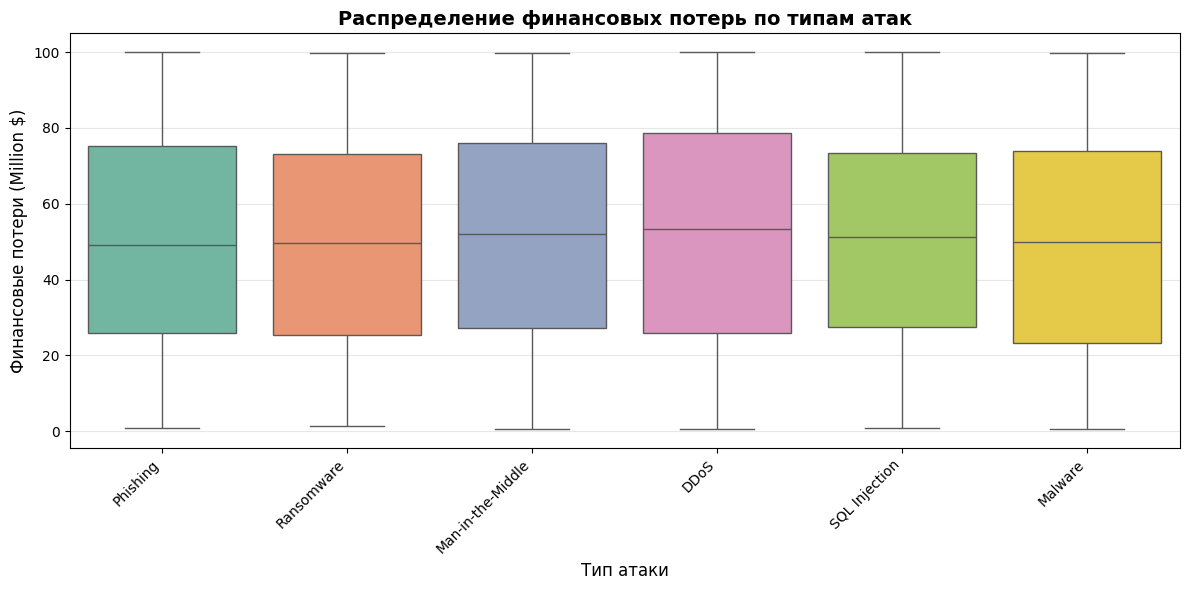

In [78]:
# Box plot: финансовые потери по типам атак
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Attack Type', y='Financial Loss (in Million $)', palette='Set2')
plt.title('Распределение финансовых потерь по типам атак', fontsize=14, fontweight='bold')
plt.xlabel('Тип атаки', fontsize=12)
plt.ylabel('Финансовые потери (Million $)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Теперь посмотрим на зависимость финансовых потерь от источников атак

/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/275507449.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


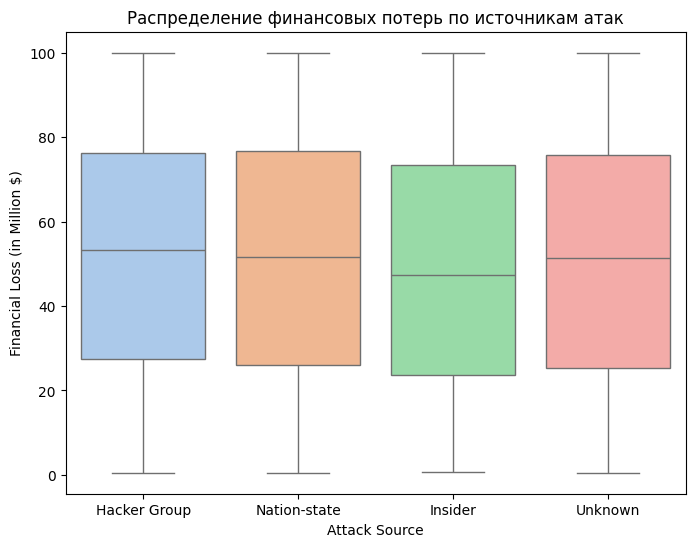

In [88]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x='Attack Source', 
    y='Financial Loss (in Million $)', 
    palette='pastel'
)
plt.title('Распределение финансовых потерь по источникам атак')
plt.ylabel('Financial Loss (in Million $)')
plt.xlabel('Attack Source')
plt.show()

### 3.4.5 Тепловая карта распределения атак по типам и отраслям


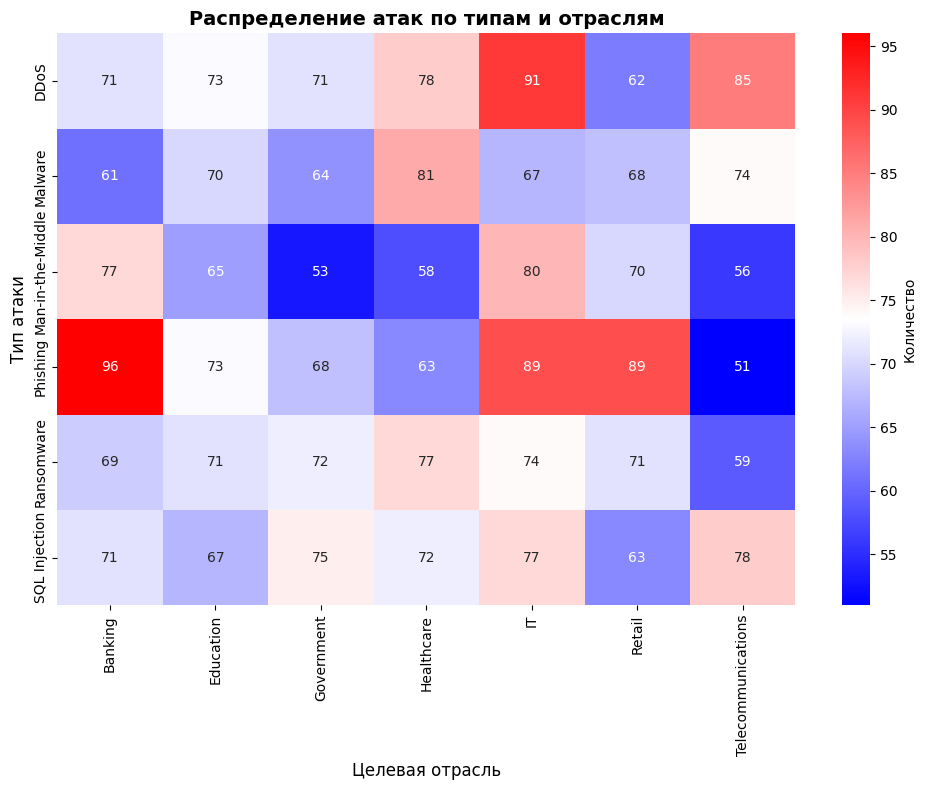

In [56]:
# Создание crosstab для анализа взаимодействия
crosstab = pd.crosstab(df['Attack Type'], df['Target Industry'])
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='bwr', cbar_kws={'label': 'Количество'})
plt.title('Распределение атак по типам и отраслям', fontsize=14, fontweight='bold')
plt.xlabel('Целевая отрасль', fontsize=12)
plt.ylabel('Тип атаки', fontsize=12)
plt.tight_layout()
plt.show()


Видим некоторые закономерности. Например, SQL Injection и Ransomware ровно распределены по всем областям. Фишинг чаще всего использовался для атак по банковской системе. ДДОС лидирует в айти и заметен в телеком индустрии.

В рамках feature Engineering можно сделать "risk_score" = частота пары (тип атаки, отрасль) для каждого кейса.

### 3.4.6 Связь между источником атаки и механизмом защиты

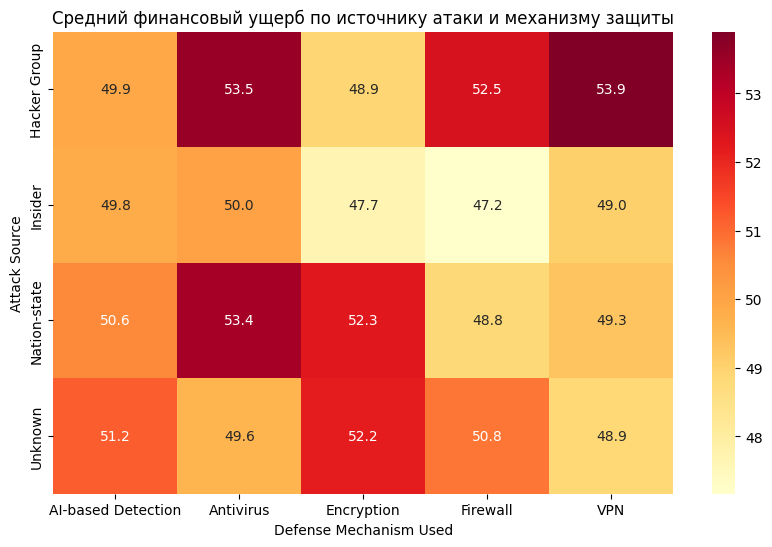

In [89]:
# Считаем средний ущерб для каждой пары (Источник атаки, Механизм защиты)
pivot_table = df.pivot_table(
    index='Attack Source',
    columns='Defense Mechanism Used',
    values='Financial Loss (in Million $)',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1f",
    cmap='YlOrRd'
)
plt.title('Средний финансовый ущерб по источнику атаки и механизму защиты')
plt.ylabel('Attack Source')
plt.xlabel('Defense Mechanism Used')
plt.show()


Независимо от источника атаки и выбранного механизма защиты, средний ущерб колеблется в довольно узком диапазоне. Это значит, что ни один механизм защиты не даёт радикального преимущества против конкретного источника атаки.Разве что, можно выделить в среднем некую слабость Insdider атак, по сравнениваю с остальными. А Hacker Group являются наиболее эффективнами в рамках нанесения финансового ущерба

### 3.4.7 Тип атаки и уязвимость, которую она эксплуатирует

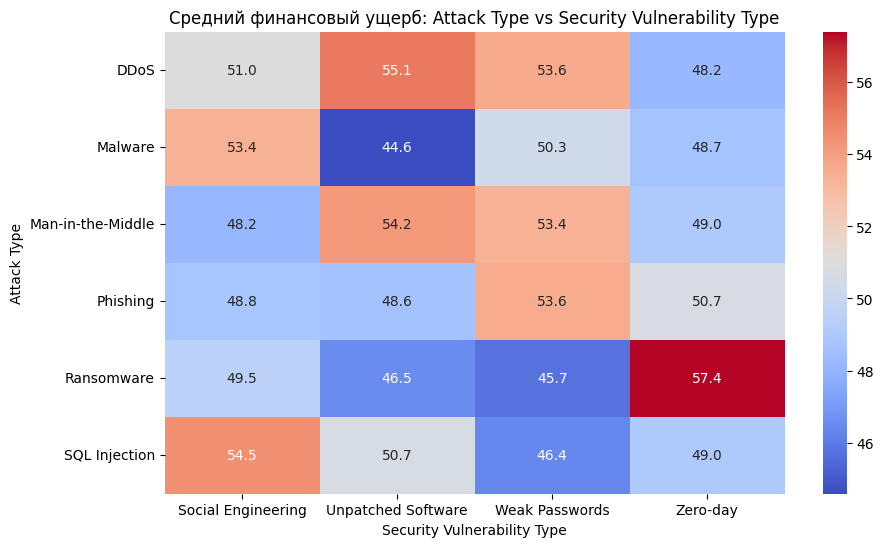

In [90]:
# Создаём сводную таблицу: строки — тип атаки, столбцы — уязвимость
pivot_table = df.pivot_table(
    index='Attack Type',
    columns='Security Vulnerability Type',
    values='Financial Loss (in Million $)',
    aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1f",
    cmap='coolwarm'
)
plt.title('Средний финансовый ущерб: Attack Type vs Security Vulnerability Type')
plt.ylabel('Attack Type')
plt.xlabel('Security Vulnerability Type')
plt.show()

Максимальный средний ущерб виден в паре “Ransomware + Zero-day” ($57.4 млн). Это типичные “дорогие” инциденты — комбо из современного вредоносного ПО и неизвестных уязвимостей. DDoS на Unpatched Software ($55.1 млн) тоже заметно выше остальных. Также. можно выделить следующие моменты:
- DDoS, Man-in-the-Middle, SQL Injection — дают заметно больший средний ущерб, если эксплуатируют незакрытые уязвимости и социальные риски.
- Combos с "Weak Passwords" не самые дорогие, кроме Phishing ($53.6 млн).

# IV. ОЧИСТКА И ПРЕДОБРАБОТКА ДАННЫХ

## 4.1 Очистка данных

In [91]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Анализ выбросов:")
for col in num_columns:
    outliers, lb, ub = detect_outliers_iqr(df[col])
    print(f"{col}: {len(outliers)} выбросов")

Анализ выбросов:
Year: 0 выбросов
Financial Loss (in Million $): 0 выбросов
Number of Affected Users: 0 выбросов
Incident Resolution Time (in Hours): 0 выбросов


Серьезные выбросы отсутствуют (наверно, стоило выбрать менее подготовленный датасет, учту на будущее)

## 4.2 Feature Engineering

In [94]:
df_featured = df.copy()

Добавим следующие признаки:

1. Attack Efficiency (финансовые потери в час) - показывает насколько эффективно с точки зрения времени наносится ущерб, сразу или атака должна быть размазанной, чтобы стать эффективной. 

2. Loss per user - покажет, являлась ли атака специально нацеленной на узкий круг лиц, либо имела массовый, хаотичный характер.

3. Risk score (кэффициент риска) для комбинации страна + отрасль + тип атаки - для каждой комбинации оценивается риск быть подверженным атаке данного типа. Так как, в случае этих данных финансовая потеря атаки зависит от совокупности факторов, считаю релевантным попытаться использовать данный признак.

Создадим признаки и исследуем их на эффективность в нашем случае

In [113]:
# 1. Attack Efficiency - финансовые потери в час
# Показывает эффективность атаки с точки зрения времени нанесения ущерба

df_featured['Attack_Efficiency'] = df_featured['Financial Loss (in Million $)'] / df_featured['Incident Resolution Time (in Hours)']

print("Attack Efficiency создан")
print(f"Диапазон значений: [{df_featured['Attack_Efficiency'].min():.2f}, {df_featured['Attack_Efficiency'].max():.2f}]")
print(f"Среднее значение: {df_featured['Attack_Efficiency'].mean():.2f}")
print(f"Медианное значение: {df_featured['Attack_Efficiency'].median():.2f}")


Attack Efficiency создан
Диапазон значений: [0.01, 99.72]
Среднее значение: 3.21
Медианное значение: 1.38


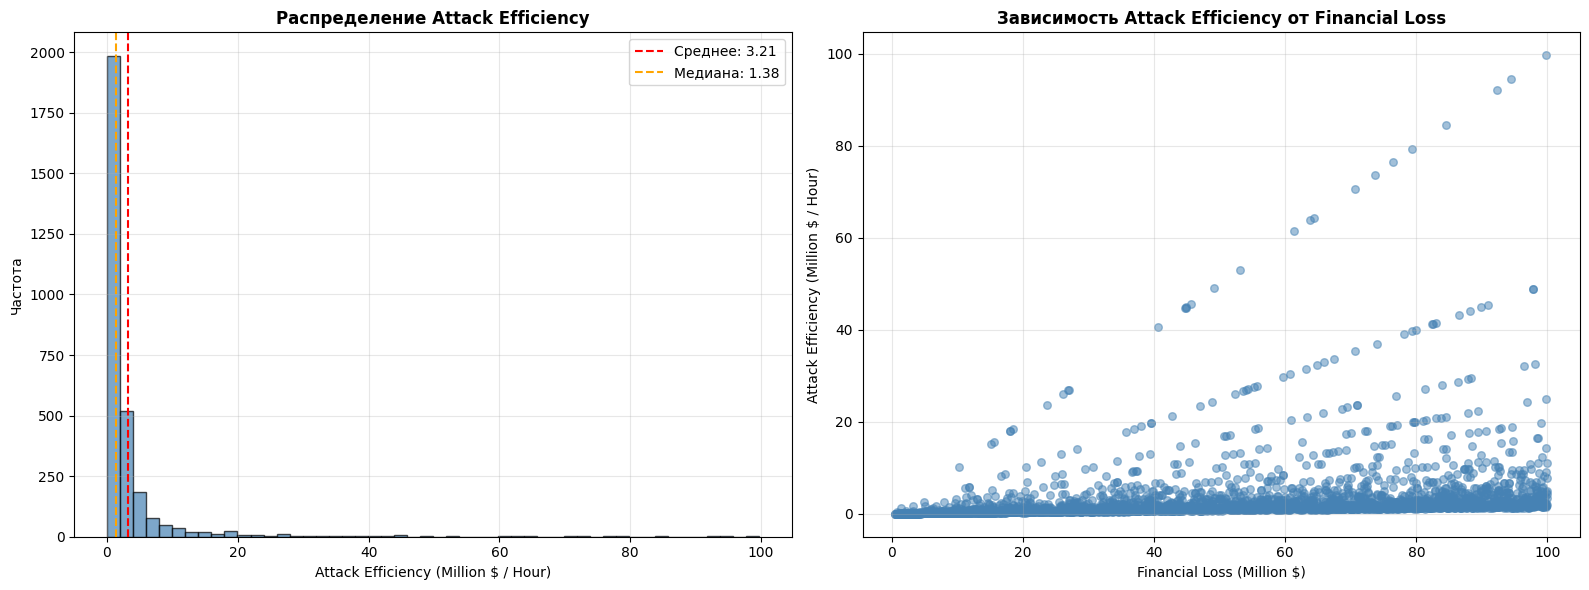

In [103]:
# Визуализация Attack Efficiency
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Гистограмма распределения
axes[0].hist(df_featured['Attack_Efficiency'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Attack Efficiency (Million $ / Hour)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение Attack Efficiency', fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axvline(df_featured['Attack_Efficiency'].mean(), color='red', linestyle='--', 
                 label=f'Среднее: {df_featured["Attack_Efficiency"].mean():.2f}')
axes[0].axvline(df_featured['Attack_Efficiency'].median(), color='orange', linestyle='--', 
                 label=f'Медиана: {df_featured["Attack_Efficiency"].median():.2f}')
axes[0].legend()

# Scatter plot: Attack Efficiency vs Financial Loss
axes[1].scatter(df_featured['Financial Loss (in Million $)'], df_featured['Attack_Efficiency'], 
                alpha=0.5, color='steelblue', s=30)
axes[1].set_xlabel('Financial Loss (Million $)')
axes[1].set_ylabel('Attack Efficiency (Million $ / Hour)')
axes[1].set_title('Зависимость Attack Efficiency от Financial Loss', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


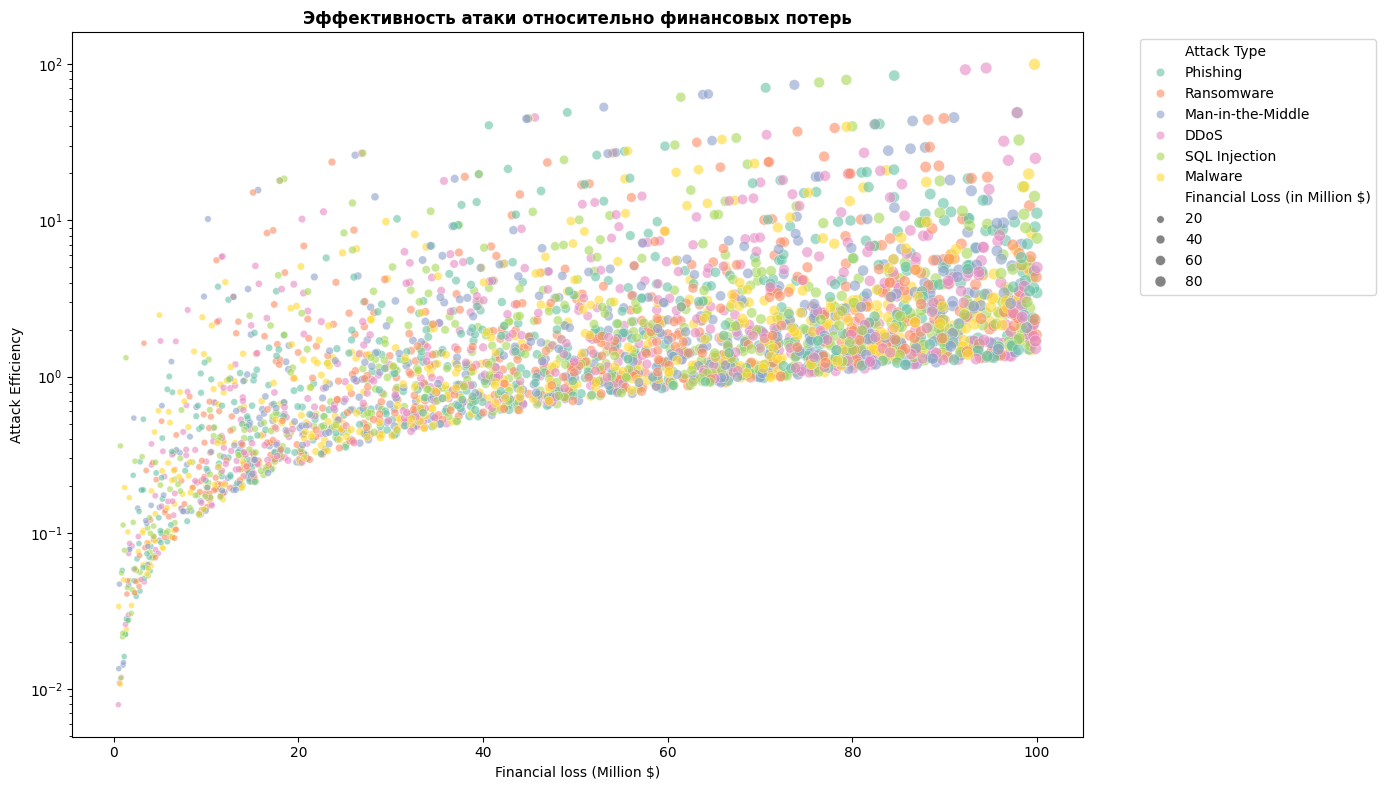

In [136]:
# Дополнительный анализ Attack Efficiency
plt.figure(figsize=(14,8))
sns.scatterplot(
    data=df_featured,
    y="Attack_Efficiency",
    x="Financial Loss (in Million $)",
    hue="Attack Type",
    size="Financial Loss (in Million $)",
    alpha=0.6,
    palette='Set2'
)
plt.xlabel('Financial loss (Million $)')
plt.ylabel('Attack Efficiency')
plt.title('Эффективность атаки относительно финансовых потерь', fontweight='bold')
#plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Attack Efficiency показывает насколько быстро наносится финансовый ущерб:
- Высокие значения: атака наносит значительный ущерб за короткое время (например, моментальная утечка данных или атака на критические системы)
- Низкие значения: атака требует времени для нанесения ущерба (постепенная эксплуатация уязвимости, длительная атака с накоплением эффекта)

Выделяется сильная левая ассиметрия, требует признак требует нормализации (log трансформации) - типичная атака это медленное кровотечение, а не стремительный удар (стабильно распределяется ущерб по часам)


In [107]:
# 2. Loss per User - показывает, насколько целевой была атака
# Высокое значение = атака нацелена на узкий круг жертв с высокой ценностью
# Низкое значение = массовая атака с хаотичным характером
# Измеряется в тысячах долларов на пользователя для лучшей читаемости

df_featured['Loss_per_User'] = (df_featured['Financial Loss (in Million $)'] / df_featured['Number of Affected Users']) * 1000

print("Loss per User создан (в тысячах долларов на пользователя)")
print(f"Диапазон значений: [{df_featured['Loss_per_User'].min():.2f}, {df_featured['Loss_per_User'].max():.2f}] тыс.$/чел")
print(f"Среднее значение: {df_featured['Loss_per_User'].mean():.2f} тыс.$/чел")
print(f"Медианное значение: {df_featured['Loss_per_User'].median():.2f} тыс.$/чел")


Loss per User создан (в тысячах долларов на пользователя)
Диапазон значений: [0.00, 141.06] тыс.$/чел
Среднее значение: 0.52 тыс.$/чел
Медианное значение: 0.10 тыс.$/чел


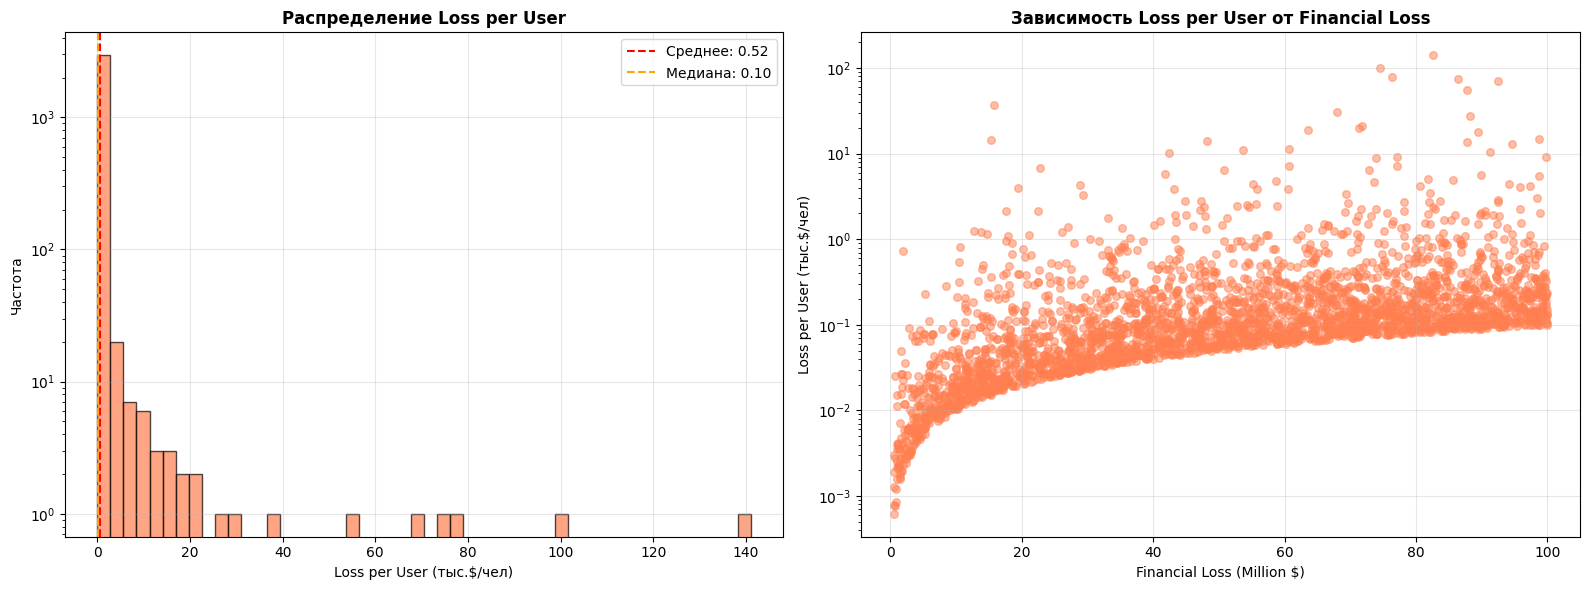

In [122]:
# Визуализация Loss per User
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Гистограмма распределения
axes[0].hist(df_featured['Loss_per_User'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Loss per User (тыс.$/чел)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение Loss per User', fontweight='bold')
#axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)
axes[0].axvline(df_featured['Loss_per_User'].mean(), color='red', linestyle='--', 
                 label=f'Среднее: {df_featured["Loss_per_User"].mean():.2f}')
axes[0].axvline(df_featured['Loss_per_User'].median(), color='orange', linestyle='--', 
                 label=f'Медиана: {df_featured["Loss_per_User"].median():.2f}')
axes[0].legend()

# Scatter plot: Loss per User vs Financial Loss
axes[1].scatter(df_featured['Financial Loss (in Million $)'], df_featured['Loss_per_User'], 
                alpha=0.5, color='coral', s=30)
axes[1].set_xlabel('Financial Loss (Million $)')
axes[1].set_ylabel('Loss per User (тыс.$/чел)')
axes[1].set_title('Зависимость Loss per User от Financial Loss', fontweight='bold')
#axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


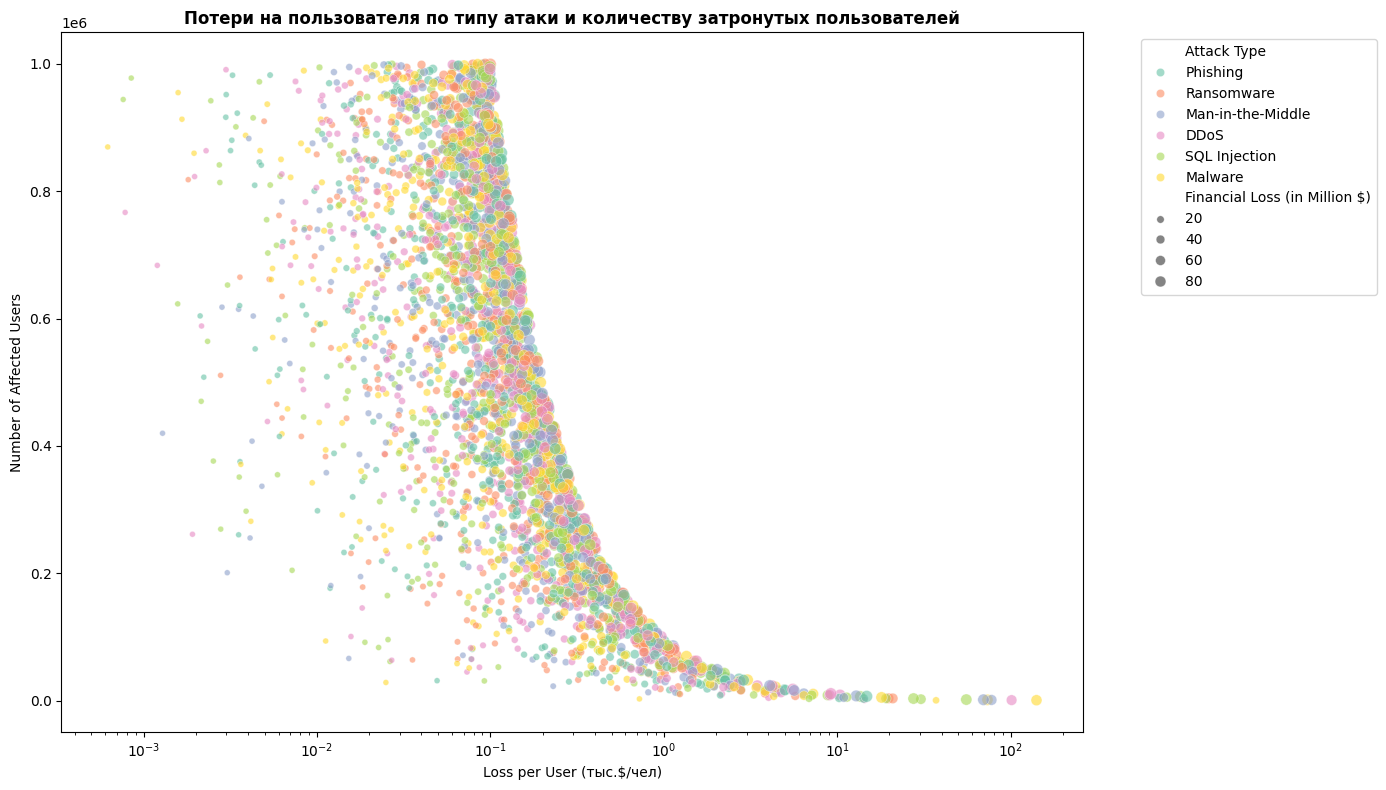

In [126]:
# Дополнительный анализ Loss per User
plt.figure(figsize=(14,8))
sns.scatterplot(
    data=df_featured,
    y="Number of Affected Users",
    x="Loss_per_User",
    hue="Attack Type",
    size="Financial Loss (in Million $)",
    alpha=0.6,
    palette='Set2'
)
plt.xlabel('Loss per User (тыс.$/чел)')
plt.ylabel('Number of Affected Users')
plt.title('Потери на пользователя по типу атаки и количеству затронутых пользователей', fontweight='bold')
plt.xscale('log')
#plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Распределение потерь на одного пользователя очень характерно: основная масса инцидентов — это небольшие суммы (до 1 тыс. $/чел), а вот дорогостоящие случаи редкость, где на пользователя приходится десятки и сотни тысяч долларов. Чем больше пользователей попадает под атаку, тем меньше потери приходится на каждого — это очевидная обратная пропорция, которая сразу бросается в глаза. Массовые атаки — это маленькая потеря для каждого, но огромная сумма в итоге. Причём, чем выше совокупные потери по инциденту, тем шире размах по Loss/User: крупные кейсы можно вычислить именно по этому признаку среди тысяч рядовых атак

In [111]:
# 3. Risk Score - коэффициент риска для комбинации страна + отрасль + тип атаки
# Оценивает, насколько опасна определенная комбинация

# Подсчитываем частоту комбинаций (Country, Target Industry, Attack Type)
country_industry_attack_counts = df_featured.groupby(['Country', 'Target Industry', 'Attack Type']).size()

# Нормализуем на максимальное значение, чтобы получить коэффициент от 0 до 1
max_count = country_industry_attack_counts.max()
country_industry_attack_risk = country_industry_attack_counts / max_count

# Создаем признак Risk_Score
df_featured['Risk_Score'] = df_featured.apply(
    lambda row: country_industry_attack_risk.get((row['Country'], row['Target Industry'], row['Attack Type']), 0.5), 
    axis=1
)

print("Risk Score создан")
print(f"Диапазон значений: [{df_featured['Risk_Score'].min():.3f}, {df_featured['Risk_Score'].max():.3f}]")
print(f"Среднее значение: {df_featured['Risk_Score'].mean():.3f}")
print(f"Медианное значение: {df_featured['Risk_Score'].median():.3f}")


Risk Score создан
Диапазон значений: [0.059, 1.000]
Среднее значение: 0.475
Медианное значение: 0.471


/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/2589123437.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(risk_data, labels=top_countries)


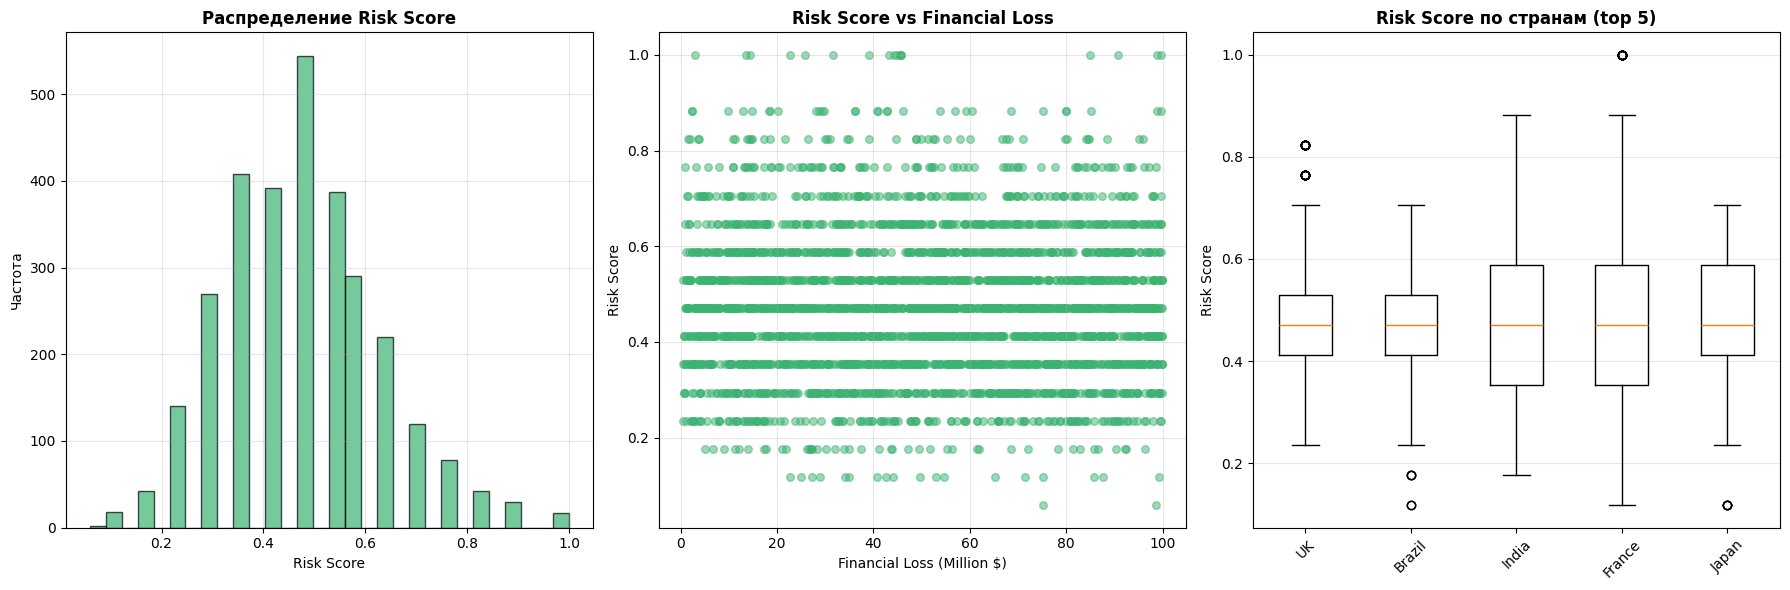

In [139]:
# Визуализация Risk Score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Risk Score - гистограмма
axes[0].hist(df_featured['Risk_Score'], bins=30, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Risk Score')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение Risk Score', fontweight='bold')
axes[0].grid(alpha=0.3)

# 2. Scatter: Risk Score vs Financial Loss
axes[1].scatter(df_featured['Financial Loss (in Million $)'], df_featured['Risk_Score'], 
                    alpha=0.5, color='mediumseagreen', s=30)
axes[1].set_xlabel('Financial Loss (Million $)')
axes[1].set_ylabel('Risk Score')
axes[1].set_title('Risk Score vs Financial Loss', fontweight='bold')
axes[1].grid(alpha=0.3)

# 3. Box plot: Risk Score по странам (top 5)
top_countries = df_featured['Country'].value_counts().head(5).index
risk_by_country = df_featured[df_featured['Country'].isin(top_countries)].groupby('Country')['Risk_Score']
risk_data = [risk_by_country.get_group(country).values for country in top_countries]

axes[2].boxplot(risk_data, labels=top_countries)
axes[2].set_ylabel('Risk Score')
axes[2].set_title('Risk Score по странам (top 5)', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


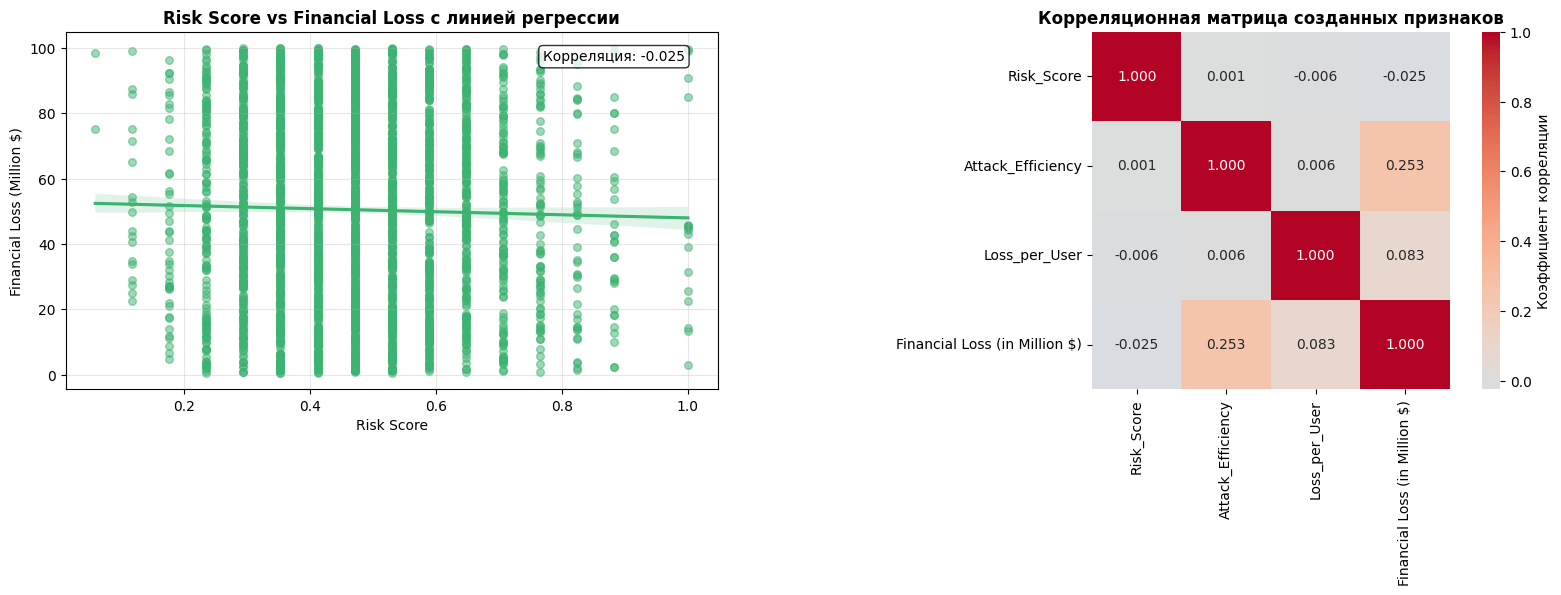


Корреляция между Risk Score и Financial Loss: -0.0250


In [142]:
# Корреляционный анализ Risk Score
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot с линией регрессии
sns.regplot(data=df_featured, x='Risk_Score', y='Financial Loss (in Million $)', 
            scatter_kws={'alpha': 0.5, 's': 30}, color='mediumseagreen', ax=axes[0])
axes[0].set_xlabel('Risk Score')
axes[0].set_ylabel('Financial Loss (Million $)')
axes[0].set_title('Risk Score vs Financial Loss с линией регрессии', fontweight='bold')
axes[0].grid(alpha=0.3)

# Вычисляем корреляцию
corr_risk = df_featured[['Risk_Score', 'Financial Loss (in Million $)']].corr().iloc[0, 1]
axes[0].text(0.95, 0.95, f'Корреляция: {corr_risk:.3f}', 
             transform=axes[0].transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Корреляционная матрица для всех созданных признаков
featured_cols = ['Risk_Score', 'Attack_Efficiency', 'Loss_per_User', 'Financial Loss (in Million $)']
corr_matrix_featured = df_featured[featured_cols].corr()

sns.heatmap(corr_matrix_featured, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, cbar_kws={'label': 'Коэффициент корреляции'}, ax=axes[1])
axes[1].set_title('Корреляционная матрица созданных признаков', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nКорреляция между Risk Score и Financial Loss: {corr_risk:.4f}")


Risk Score показывает относительную частоту конкретного сочетания "страна + отрасль + тип атаки". Значение близкое к 1.0 означает, что это самая частая комбинация в истории инцидентов (максимальный риск повторения), а близкое к 0 — редкий, почти уникальный кейс. При это, не наблюдается явная линейная зависимость между risc score и целевой переменной. По странам признак распределен довольно равномерно, что в очедной раз подтверждает факт того, что все страны в выборке подвержены инцидентам равномерно. Возможно, для использования лучше подойдет анализ среднего ущерба для каждой комбинации.

Этот признак показывает сколько денег в среднем теряли компании с таким же контекстом атаки раньше. Чем выше Risk_Score_Mean, тем опаснее именно такой профиль инцидента для бизнеса с точки зрения денег.

In [140]:
risk_score_mean = df_featured.groupby(['Country', 'Target Industry', 'Attack Type'])['Financial Loss (in Million $)'].mean()
df_featured['Risk_Score_Mean'] = df_featured.apply(
    lambda row: risk_score_mean.get((row['Country'], row['Target Industry'], row['Attack Type']), 50.0), 
    axis=1
)


/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/2024481447.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(risk_mean_data, labels=top_countries)


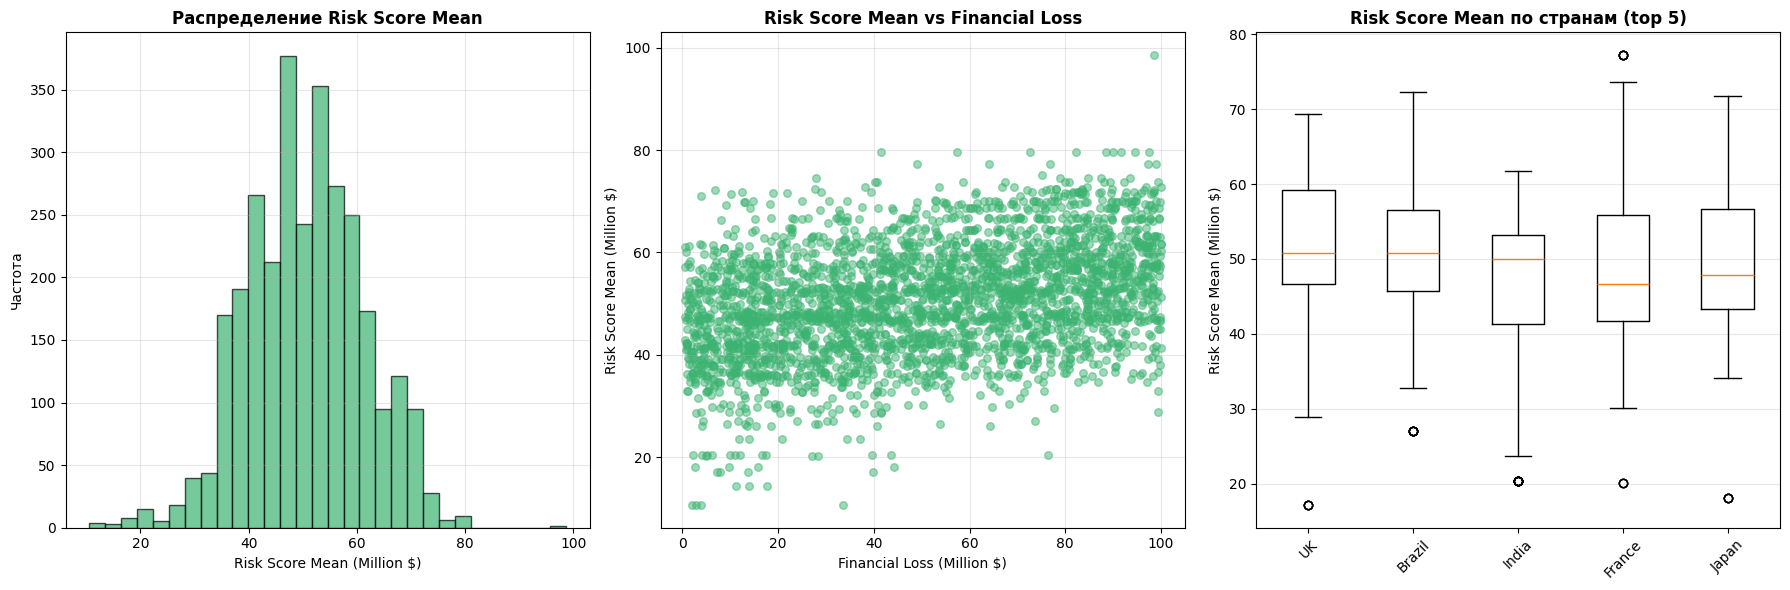

In [141]:
# Визуализация Risk Score Mean
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Risk Score Mean - гистограмма
axes[0].hist(df_featured['Risk_Score_Mean'], bins=30, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Risk Score Mean (Million $)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение Risk Score Mean', fontweight='bold')
axes[0].grid(alpha=0.3)

# 2. Scatter: Risk Score Mean vs Financial Loss
axes[1].scatter(df_featured['Financial Loss (in Million $)'], df_featured['Risk_Score_Mean'], 
                    alpha=0.5, color='mediumseagreen', s=30)
axes[1].set_xlabel('Financial Loss (Million $)')
axes[1].set_ylabel('Risk Score Mean (Million $)')
axes[1].set_title('Risk Score Mean vs Financial Loss', fontweight='bold')
axes[1].grid(alpha=0.3)

# 3. Box plot: Risk Score Mean по странам (top 5)
top_countries = df_featured['Country'].value_counts().head(5).index
risk_mean_by_country = df_featured[df_featured['Country'].isin(top_countries)].groupby('Country')['Risk_Score_Mean']
risk_mean_data = [risk_mean_by_country.get_group(country).values for country in top_countries]

axes[2].boxplot(risk_mean_data, labels=top_countries)
axes[2].set_ylabel('Risk Score Mean (Million $)')
axes[2].set_title('Risk Score Mean по странам (top 5)', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


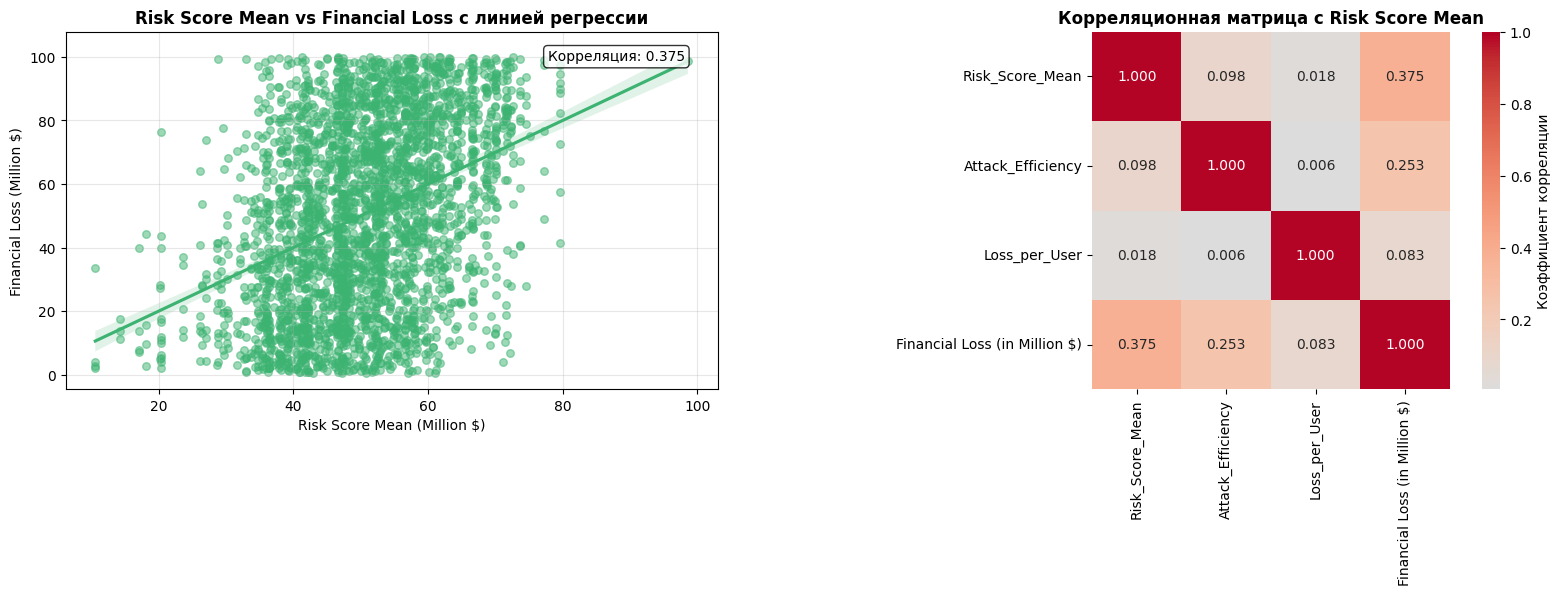


Корреляция Risk Score Mean с Financial Loss: 0.3748


In [145]:
# Корреляционный анализ Risk Score Mean
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot с линией регрессии
sns.regplot(data=df_featured, x='Risk_Score_Mean', y='Financial Loss (in Million $)', 
            scatter_kws={'alpha': 0.5, 's': 30}, color='mediumseagreen', ax=axes[0])
axes[0].set_xlabel('Risk Score Mean (Million $)')
axes[0].set_ylabel('Financial Loss (Million $)')
axes[0].set_title('Risk Score Mean vs Financial Loss с линией регрессии', fontweight='bold')
axes[0].grid(alpha=0.3)

# Вычисляем корреляцию
corr_risk_mean = df_featured[['Risk_Score_Mean', 'Financial Loss (in Million $)']].corr().iloc[0, 1]
axes[0].text(0.95, 0.95, f'Корреляция: {corr_risk_mean:.3f}', 
             transform=axes[0].transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Корреляционная матрица для Risk Score Mean и других признаков
featured_cols_mean = ['Risk_Score_Mean', 'Attack_Efficiency', 'Loss_per_User', 'Financial Loss (in Million $)']
corr_matrix_mean = df_featured[featured_cols_mean].corr()

sns.heatmap(corr_matrix_mean, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, cbar_kws={'label': 'Коэффициент корреляции'}, ax=axes[1])
axes[1].set_title('Корреляционная матрица с Risk Score Mean', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nКорреляция Risk Score Mean с Financial Loss: {corr_risk_mean:.4f}")


Распределение признака похоже на нормальное, хорошая симметричность. Корреляция с целевой переменной около 37 процентов, диагональнаял линия тенденции четко показывает связь средней оценки риска с финансовыми потерями. В боксплоте распределения по странам видно, что нет значительных различий - инциденты распределены равномерно, есть редкие выбросы.

Среди всех созданных признаков, считаю этот самым вариативным. В отличие от признака Risk_Score на основе частоты (который показал корреляцию близкую к нулю), Risk_Score_Mean напрямую кодирует информацию о реальных потерях и позволяет модели лучше улавливать паттерны: чем выше исторический средний ущерб для данного контекста инцидента, тем выше ожидаемые финансовые потери.

Удалим признак risc_score из датасета за ненадобностью

In [146]:
# Удаляем Risk_Score из датасета, так как Risk_Score_Mean показал лучшую корреляцию с целевой переменной
df_featured = df_featured.drop(columns=['Risk_Score'])
print(f"Удален признак Risk_Score. Размерность датасета: {df_featured.shape}")
print(f"Столбцы: {list(df_featured.columns)}")

Удален признак Risk_Score. Размерность датасета: (3000, 13)
Столбцы: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Incident Resolution Time (in Hours)', 'Attack_Efficiency', 'Loss_per_User', 'Risk_Score_Mean']


# V. ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ

## 5.1 Используем StandartScaler для числовых признаков

Признаки достаточно чистые, без явных выбросов. Достаточно привести все признаки к одному масштабу для работы линейной регрессии. Целевую переменную не будем трогать, чтобы избежать ошибок при обратном масштабировании и при интерпретации результатов

In [150]:
df_normalized = df_featured.copy()
scalers = {}

# Только числовые признаки (исключаем категориальные и целевую переменную)
num_columns = ['Attack_Efficiency', 'Loss_per_User', 'Risk_Score_Mean', 
               'Number of Affected Users', 'Incident Resolution Time (in Hours)']

# Создаем нормализованные версии
for col in num_columns:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_featured[[col]])
    scalers[col] = scaler
    df_normalized[f'{col}_scaled'] = scaled

# Удаляем исходные числовые колонки (оставляем только нормализованные)
df_normalized = df_normalized.drop(columns=num_columns)

print(f"Нормализованы {len(num_columns)} признаков")
print(f"Новая размерность: {df_normalized.shape}")

Нормализованы 5 признаков
Новая размерность: (3000, 13)


In [151]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Country                                     3000 non-null   object 
 1   Year                                        3000 non-null   int64  
 2   Attack Type                                 3000 non-null   object 
 3   Target Industry                             3000 non-null   object 
 4   Financial Loss (in Million $)               3000 non-null   float64
 5   Attack Source                               3000 non-null   object 
 6   Security Vulnerability Type                 3000 non-null   object 
 7   Defense Mechanism Used                      3000 non-null   object 
 8   Attack_Efficiency_scaled                    3000 non-null   float64
 9   Loss_per_User_scaled                        3000 non-null   float64
 10  Risk_Score_M

## 5.2 Преобразование категориальных признаков

### One-Hot кодирование

In [152]:
# Создаем список категориальных признаков для датасета df_normalized (включая Year)
cat_columns_normalized = ['Country', 'Year', 'Attack Type', 'Target Industry', 
                          'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']

# Применяем One-Hot Encoding ко всем категориальным признакам
onehot_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(df_normalized[cat_columns_normalized])

feature_names = onehot_encoder.get_feature_names_out(cat_columns_normalized)
print(f"Категориальные признаки: {cat_columns_normalized}")
print(f"Создано закодированных признаков: {len(feature_names)}")
print(f"Исходных категориальных признаков: {len(cat_columns_normalized)}")

Категориальные признаки: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']
Создано закодированных признаков: 46
Исходных категориальных признаков: 7


In [154]:
# Создаем датасет с нормализованными числовыми и закодированными категориальными признаками
# Создаем DataFrame из закодированных категориальных признаков
df_onehot = pd.DataFrame(onehot_encoded, columns=feature_names)

# Создаем финальный датасет: оставляем только целевой признак и нормализованные числовые
df_final = df_normalized[['Financial Loss (in Million $)']].copy()

# Добавляем нормализованные числовые признаки
numeric_scaled_columns = ['Attack_Efficiency_scaled', 'Loss_per_User_scaled', 'Risk_Score_Mean_scaled',
                          'Number of Affected Users_scaled', 'Incident Resolution Time (in Hours)_scaled']
for col in numeric_scaled_columns:
    df_final[col] = df_normalized[col].values

# Добавляем закодированные категориальные признаки
for col in feature_names:
    df_final[col] = df_onehot[col].values

print(f"Финальный датасет создан")
print(f"Размерность: {df_final.shape}")
print(f"Колонки:")
print(f"  - Целевая переменная: Financial Loss (in Million $)")
print(f"  - Нормализованные числовые признаки: {len(numeric_scaled_columns)}")
print(f"  - Закодированные категориальные признаки: {len(feature_names)}")
print(f"\nВсего признаков: {df_final.shape[1]}")


Финальный датасет создан
Размерность: (3000, 52)
Колонки:
  - Целевая переменная: Financial Loss (in Million $)
  - Нормализованные числовые признаки: 5
  - Закодированные категориальные признаки: 46

Всего признаков: 52


# VI. АВТОМАТИЗАЦИЯ ПРЕДОБРАБОТКИ (PIPELINE)

## 6.1 Создание собственных трансформеров

In [15]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
    
    def fit(self, X, y=None):
        self.lower_bound = np.quantile(X, self.lower_quantile)
        self.upper_bound = np.quantile(X, self.upper_quantile)
        return self
    
    def transform(self, X):
        X = X.copy()
        X[X < self.lower_bound] = self.lower_bound
        X[X > self.upper_bound] = self.upper_bound
        return X

print("QuantileReplacer создан")

QuantileReplacer создан


In [16]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        X = np.array(X).flatten()
        value_counts = pd.Series(X).value_counts()
        self.common_categories = value_counts[value_counts / len(X) >= self.threshold].index.tolist()
        return self
    
    def transform(self, X):
        X = pd.Series(np.array(X).flatten())
        X = X.where(X.isin(self.common_categories), 'Rare')
        return np.array(X).reshape(-1, 1)

print("RareGrouper создан")

RareGrouper создан


## 6.2 Построение Pipeline

In [17]:
numeric_pipeline = Pipeline([
    ('scaler', PowerTransformer(method='yeo-johnson'))
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

print("Pipeline создан")

Pipeline создан


## 6.3 ColumnTransformer

In [ ]:
target = 'Financial Loss (in Million $)'
numeric_features = [col for col in num_columns if col != target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, cat_columns)
    ],
    remainder='drop'
)

X = df_featured.drop(columns=[target])
y = df_featured[target]

X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

print(f"Исходная размерность: {X.shape}")
print(f"Преобразованная размерность: {X_transformed.shape}")
print(f"Создано признаков: {len(feature_names)}")

Исходная размерность: (3000, 10)
Преобразованная размерность: (3000, 39)
Создано признаков: 39


# VII. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

In [ ]:
df_processed = pd.DataFrame(X_transformed, columns=feature_names)
df_processed['Financial_Loss'] = y.values

df_processed.to_csv('processed_data.csv', index=False)
print("Данные сохранены в processed_data.csv")
print(f"Итоговая размерность: {df_processed.shape}")

# VIII. ВЫВОДЫ И РЕКОМЕНДАЦИИ

## 8.1 Краткое резюме

### Основные этапы:
1. Загрузка данных (3000 записей, 10 признаков)
2. EDA - разведочный анализ данных
3. Очистка от выбросов
4. Применение PowerTransformer для числовых признаков
5. One-Hot кодирование для категориальных признаков
6. Создание Pipeline для воспроизводимости

## 8.2 Интерпретация визуализаций

- Financial Loss коррелирует с количеством затронутых пользователей
- Различные типы атак показывают разные уровни потерь
- Время разрешения влияет на финансовые потери

## 8.3 Рекомендации для моделирования

### Информативные признаки:
- Number of Affected Users
- Attack Type
- Incident Resolution Time

### Эффективные преобразования:
- PowerTransformer для числовых признаков
- OneHotEncoder для категориальных

### Следующие шаги:
1. Разделение на train/test
2. Обучение моделей (LinearRegression, RandomForest)
3. Оценка качества (R², RMSE, MAE)
4. Оптимизация гиперпараметров

## 8.4 Объяснение: Почему важна нормализация?

### Что означает "нормальное распределение при логарифмической шкале"?

**Основная идея:**

1. **Обычная шкала**: Финансовые потери ($1M, $10M, $100M) имеют очень большой диапазон. Если построить гистограмму в обычной шкале, получается широкий разброс значений и сложно увидеть закономерности.

2. **Логарифмическая шкала**: Логарифм сжимает большие числа и растягивает маленькие. Например:
   - $1M → log₁₀(1) = 0
   - $10M → log₁₀(10) = 1  
   - $100M → log₁₀(100) = 2

3. **Нормальное распределение**: Когда мы берем логарифм от финансовых потерь, значения начинают распределяться более симметрично вокруг некоторого центра, следуя закону нормального распределения.

**Почему это важно для машинного обучения:**

- ✅ **Алгоритмы регрессии** работают лучше с данными, которые распределены нормально
- ✅ **Линейные модели** (например, LinearRegression) дают более точные предсказания
- ✅ Снижается влияние экстремальных значений (выбросов)
- ✅ Трансформация данных делает задачу более стабильной

**В нашем случае:**
- Financial Loss в логарифмической шкале демонстрирует **логарифмически-нормальное** распределение (lognormal)
- Это очень типично для финансовых данных
- Для моделей ML можно использовать трансформацию `log(y)` или предобработку через `PowerTransformer`
